In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tensorflow import keras
from torch.utils.data import Dataset
import torch.nn.functional as F

/home/cyy/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-24 08:48:42.196817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 08:48:42.197023: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class MNISTDataset(Dataset):
    def __init__(self, image, label):
        self.image = torch.tensor(image, dtype = torch.float32)
        self.label = label

    def __len__(self): return len(self.label)

    def __getitem__(self, idx):
        image_ = self.image[idx]
        image_ = image_[None, :]
        label_ = self.label[idx]
        return image_, label_
        

In [4]:
(x_tr, y_tr), (x_ts, y_ts) = keras.datasets.mnist.load_data()
trainset = MNISTDataset(x_tr, y_tr)
valset = MNISTDataset(x_ts, y_ts)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 500

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [11]:
# from torch.autograd import grad

# def nth_derivative(f, wrt, n):

#     for i in range(n):

#         grads = grad(f, wrt, create_graph=True)[0]
#         f = grads.sum()

#     return grads

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    data.requires_grad_(True)
    
    optimizer.zero_grad()
    output = network(data)
    # print(output.shape)
    
    loss = F.nll_loss(output, target)
    loss.backward()
    first_derivative = data.grad
    print(first_derivative.shape)

    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
         (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
      
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [17]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in valloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(valloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(valloader.dataset),
    100. * correct / len(valloader.dataset)))

In [36]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_300/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/cyy/.local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2691, Accuracy: 9285/10000 (93%)

torch.Size([64, 10])


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
def scores(loader):
    network.eval()
    # outputs = [] 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = network(data)
            # outputs.append(output)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    return output

In [ ]:
trloader = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False)
tsloader = torch.utils.data.DataLoader(valset, batch_size=10000, shuffle=False)

In [ ]:
train_score = scores(trloader)
test_score = scores(tsloader)

/tmp/ipykernel_964/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1178, Accuracy: 57779/60000 (96%)


Test set: Avg. loss: 0.1224, Accuracy: 9613/10000 (96%)



In [ ]:
train_score.shape

torch.Size([60000, 10])

In [38]:
torch.save(train_score, 'train_score.pt')
torch.save(test_score, 'test_score.pt')

NameError: name 'test_score' is not defined

In [39]:
train_score = torch.load('train_score.pt')
train_score.shape

torch.Size([60000, 10])

In [12]:
y_tr[0:200].shape

(200,)

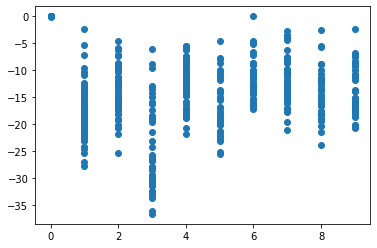

In [40]:
plt.scatter(y_tr[0:500], train_score[0:500, 0])
plt.show()
# torch.scatter(train_score[0:200, 0], index = torch.from_numpy(y_tr[0:200]))